### Midterm: IT Application in Banking and Finance

**Student name**: Tran Trung Chien

**Student code**: 2112343020

**Class code**: ML71

**Submitted documents**: 3 files
- 1 pdf file
- 1 notebook file (.ipynb)
- 1 mgarch_model file (.py file contains BEKK, DCC, ADCC, and cDCC model built manually)

# Question 1

## Get crypto data (ETH, LINK, NEAR) from Binance API

### Import necessary libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MetaTrader5 as mt
import os
from dotenv import load_dotenv
from datetime import datetime, timedelta

### Stream the data

In [9]:
mt.initialize()

True

In [17]:
load_dotenv()

login = int(os.getenv("LOGIN"))
server = os.getenv("SERVER")
password = os.getenv("PASSWORD")
mt.login(login=login, server=server, password=password)

True

In [33]:
def load_stock_data(ticker, start_date, end_date):
    df = pd.DataFrame(mt.copy_rates_range(
        ticker,
        mt.TIMEFRAME_D1,
        start_date,
        end_date
    ))
    df['time'] = pd.to_datetime(df['time'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')
    df.drop(['spread', 'real_volume'], axis=1, inplace=True)
    df.set_index('time', inplace=True)
    return df['close']

tickers = ['AAPL', 'AMD', 'MSFT']

forex_data = {}

start_date = datetime(2015, 1, 1)
end_date = datetime(2024, 10, 15)

# start_date = datetime(2010, 1, 1)
# end_date = datetime(2018, 10, 15)

for ticker in tickers:
    lowercase_ticker = ticker.lower()
    forex_data[lowercase_ticker] = load_stock_data(ticker, start_date, end_date)

close_matrix = pd.DataFrame({ticker.lower(): forex_data[ticker.lower()] for ticker in tickers})
close_matrix.ffill(inplace=True)
close_matrix.index = pd.to_datetime(close_matrix.index)
print("Close Matrix:\n")
display(close_matrix)

Close Matrix:



,aapl,amd,msft
time,,,
2015-01-02,27.32,2.69,46.76
2015-01-05,26.58,2.66,46.36
2015-01-06,26.55,2.63,45.63
2015-01-07,26.93,2.57,46.21
2015-01-08,27.95,2.61,47.62
...,...,...,...
2024-10-08,225.82,172.93,415.04
2024-10-09,229.71,171.09,417.69
2024-10-10,229.14,164.18,416.09


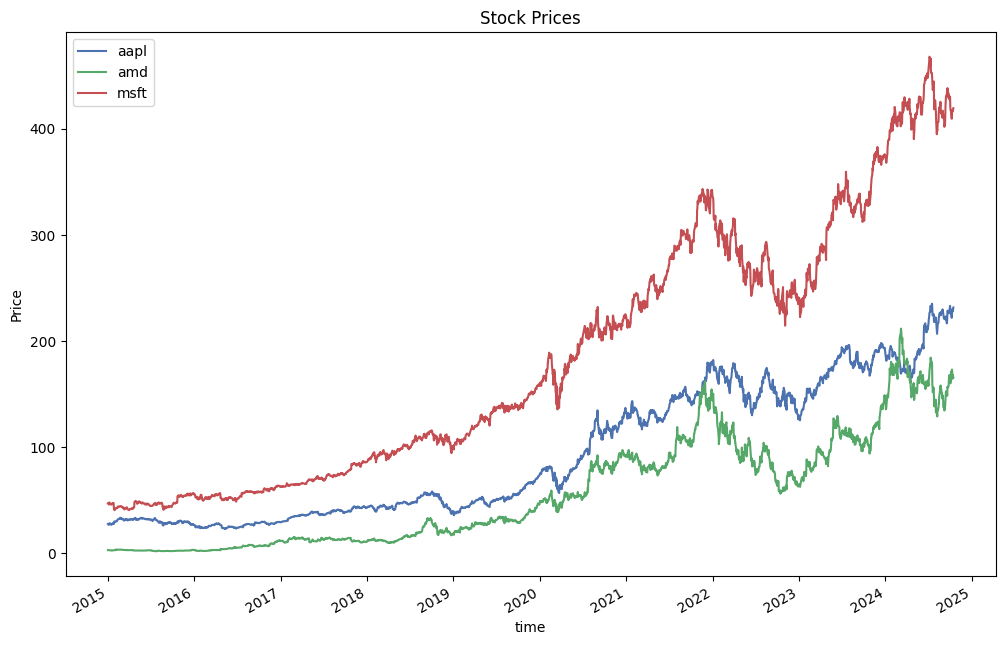

In [65]:
close_matrix.plot(figsize=(12, 8))
plt.title('Stock Prices')
plt.ylabel('Price')
plt.show();

## 1.1. Construct equally-weighted, minimum variance, optimize stock, rand weights portfolios

In [38]:
import pandas as pd
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt import CLA, plotting

In [53]:
mu = expected_returns.mean_historical_return(close_matrix)
S = risk_models.CovarianceShrinkage(close_matrix).ledoit_wolf()

n_assets = len(close_matrix.columns)
equal_weights = np.array([1/n_assets] * n_assets)

# Create the portfolio using Efficient Frontier
ef = EfficientFrontier(mu, S)
ef.set_weights({col: 1/n_assets for col in close_matrix.columns})
portfolio_performance = ef.portfolio_performance(verbose=True)

print("Weights for each stock:", equal_weights.round(2))

# Calculate performance metrics
expected_return, volatility, sharpe_ratio = ef.portfolio_performance()
print("Portfolio Expected Annual Return:", expected_return)
print("Portfolio Annual Volatility:", volatility)
print("Portfolio Sharpe Ratio:", sharpe_ratio)


Expected annual return: 34.0%
Annual volatility: 30.9%
Sharpe Ratio: 1.04
Weights for each stock: [0.33 0.33 0.33]
Portfolio Expected Annual Return: 0.34028112251325615
Portfolio Annual Volatility: 0.30858343112884895
Portfolio Sharpe Ratio: 1.0379077105391403


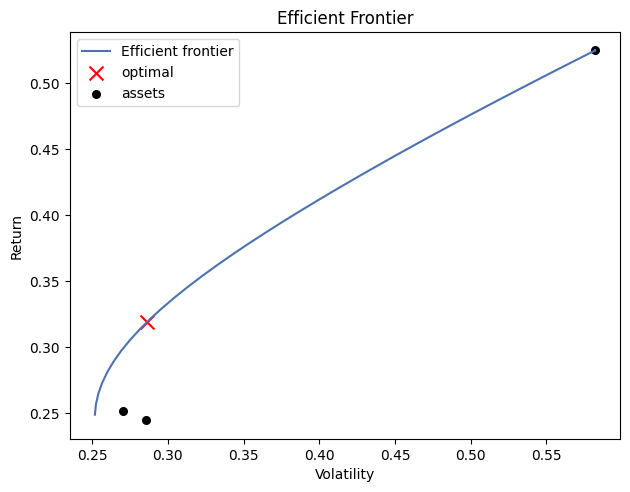

In [58]:
cla = CLA(mu, S)
ax = plotting.plot_efficient_frontier(cla, showfig=False)
plt.title("Efficient Frontier")
plt.show()

## 1.2. Calculate log returns, absolute returns, squared returns of the series, descriptive statistics, stationary test

### 1.2.1. Calculate returns

In [28]:
df['ret_port'] = (df['ret_ETH'] + df['ret_LINK'] + df['ret_NEAR'])/3 # calculate portfolio return

# calculate absolute returns
eth_abs_ret = ((df['ETH'] - df['ETH'].iloc[0])/df['ETH'].iloc[0]) * 100
link_abs_ret = ((df['LINK'] - df['LINK'].iloc[0])/df['LINK'].iloc[0]) * 100
near_abs_ret = ((df['NEAR'] - df['NEAR'].iloc[0])/df['NEAR'].iloc[0]) * 100

# calculate squared returns
eth_sq_ret = np.square(df['ret_ETH'])
link_sq_ret = np.square(df['ret_LINK'])
near_sq_ret = np.square(df['ret_NEAR'])
port_sq_ret = np.square(df['ret_port']) 

In [29]:
df

,ETH,LINK,NEAR,ret_ETH,ret_LINK,ret_NEAR,ret_port
date,,,,,,,
2020-10-15 08:00:00,377.63,10.752,1.1220,-0.032895,-0.016126,-0.318944,-0.122655
2020-10-16 08:00:00,365.41,10.580,0.8156,0.007769,0.003397,-0.009486,0.000560
2020-10-17 08:00:00,368.26,10.616,0.8079,0.026872,0.029698,0.074285,0.043618
2020-10-18 08:00:00,378.29,10.936,0.8702,0.003114,-0.001464,-0.082363,-0.026904
2020-10-19 08:00:00,379.47,10.920,0.8014,-0.028684,-0.102921,-0.168837,-0.100147
...,...,...,...,...,...,...,...
2024-05-15 08:00:00,3030.66,13.861,8.0490,-0.029276,0.111954,-0.003984,0.026232
2024-05-16 08:00:00,2943.22,15.503,8.0170,0.048822,0.045335,0.001994,0.032050
2024-05-17 08:00:00,3090.48,16.222,8.0330,0.010016,0.006023,-0.014546,0.000498


### Plotting the Log Returns

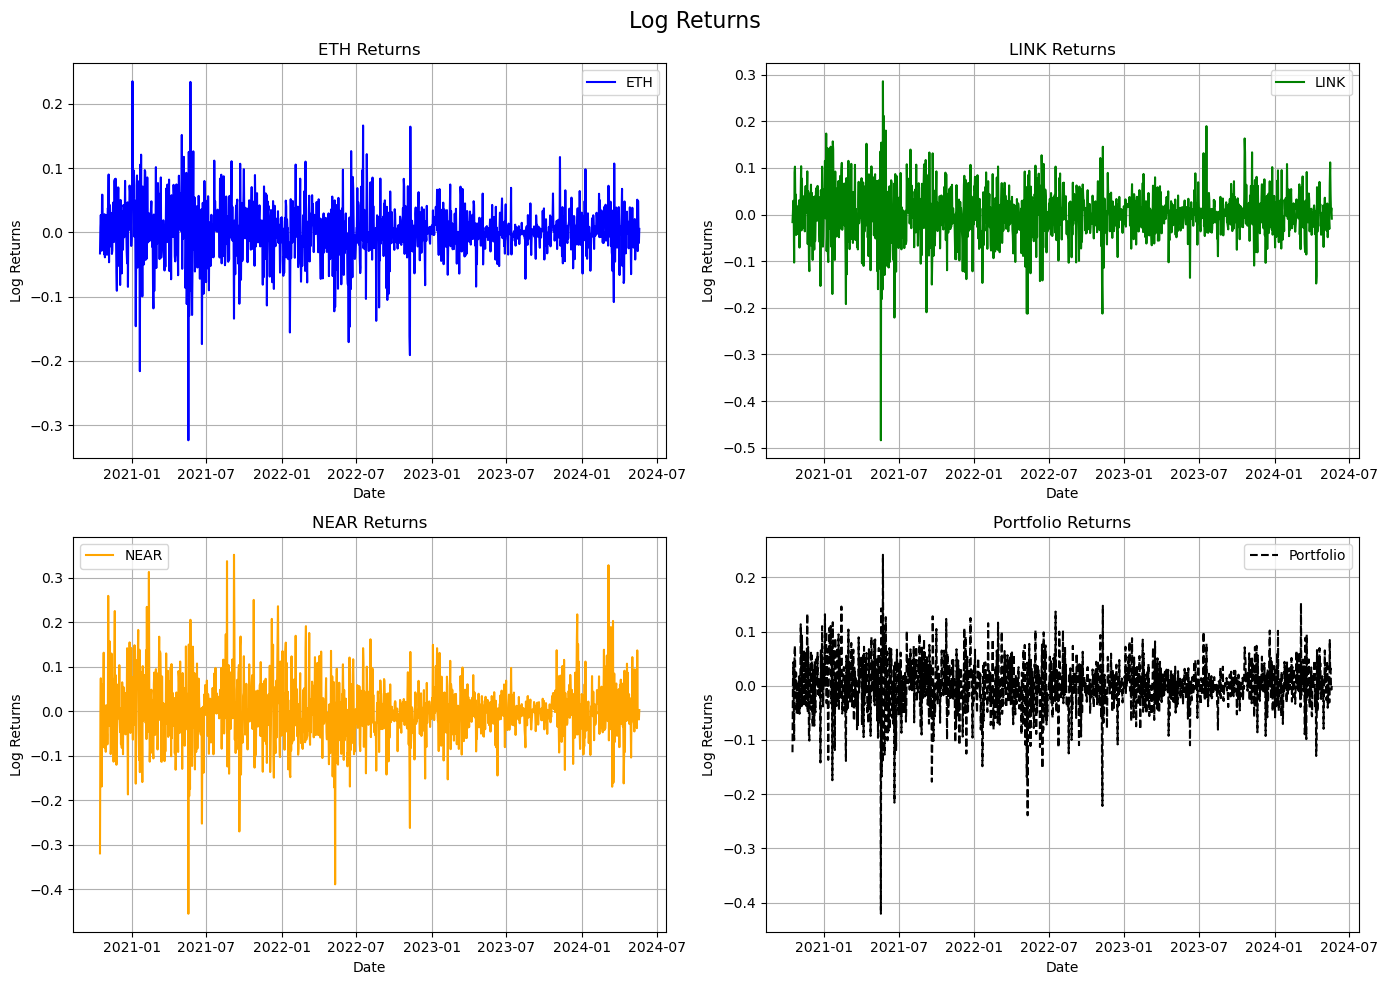

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(df['ret_ETH'], label='ETH', color='blue')
axs[0, 0].set_title('ETH Returns')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Log Returns')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(df['ret_LINK'], label='LINK', color='green')
axs[0, 1].set_title('LINK Returns')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Log Returns')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(df['ret_NEAR'], label='NEAR', color='orange')
axs[1, 0].set_title('NEAR Returns')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Log Returns')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(df['ret_port'], label='Portfolio', linestyle='--', color='black')
axs[1, 1].set_title('Portfolio Returns')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Log Returns')
axs[1, 1].legend()
axs[1, 1].grid(True)

fig.suptitle('Log Returns', fontsize=16)
plt.tight_layout()
plt.show()

- **ETH Log Returns (Top Left)**

    - **Volatility**: Ethereum shows significant volatility, with log returns frequently spiking both positively and negatively. This high volatility is typical for cryptocurrencies, which are known for their rapid price changes.

    - **Trend**: There is no clear long-term upward or downward trend in the data, indicating that ETH's price fluctuations are relatively symmetric around the mean.

- **LINK Log Returns (Top Right)**

    - **Volatility**: LINK also exhibits substantial volatility, although the range of returns is slightly less extreme than ETH's. The log returns are clustered more densely, suggesting slightly less extreme short-term price changes compared to ETH.

    - **Consistency**: The returns show a consistent variability over the period, without any apparent increase or decrease in volatility over time.

- **NEAR Log Returns (Bottom Left)**

    - **Volatility**: NEAR exhibits a range of returns somewhat similar to that of the individual assets but appears slightly more stable.

    - **Peaks**: The occasional spikes in returns suggest that there are still times of significant profit or loss, which could be due to the performance of specific assets within the portfolio or market events impacting the portfolio's overall value.

- **Portfolio Log Returns (Bottom Right)**

    - **Volatility**: This portfolio appears to have the highest frequency of returns clustered around the mean, which suggests it's more diversified or balanced compared to the individual assets.
    
    - **Stability**: The returns are more consistent, with fewer extreme values compared to the individual cryptocurrencies. This stability is a typical advantage of diversified portfolios, which can spread risk across different assets.

### Plotting the Absolute Returns

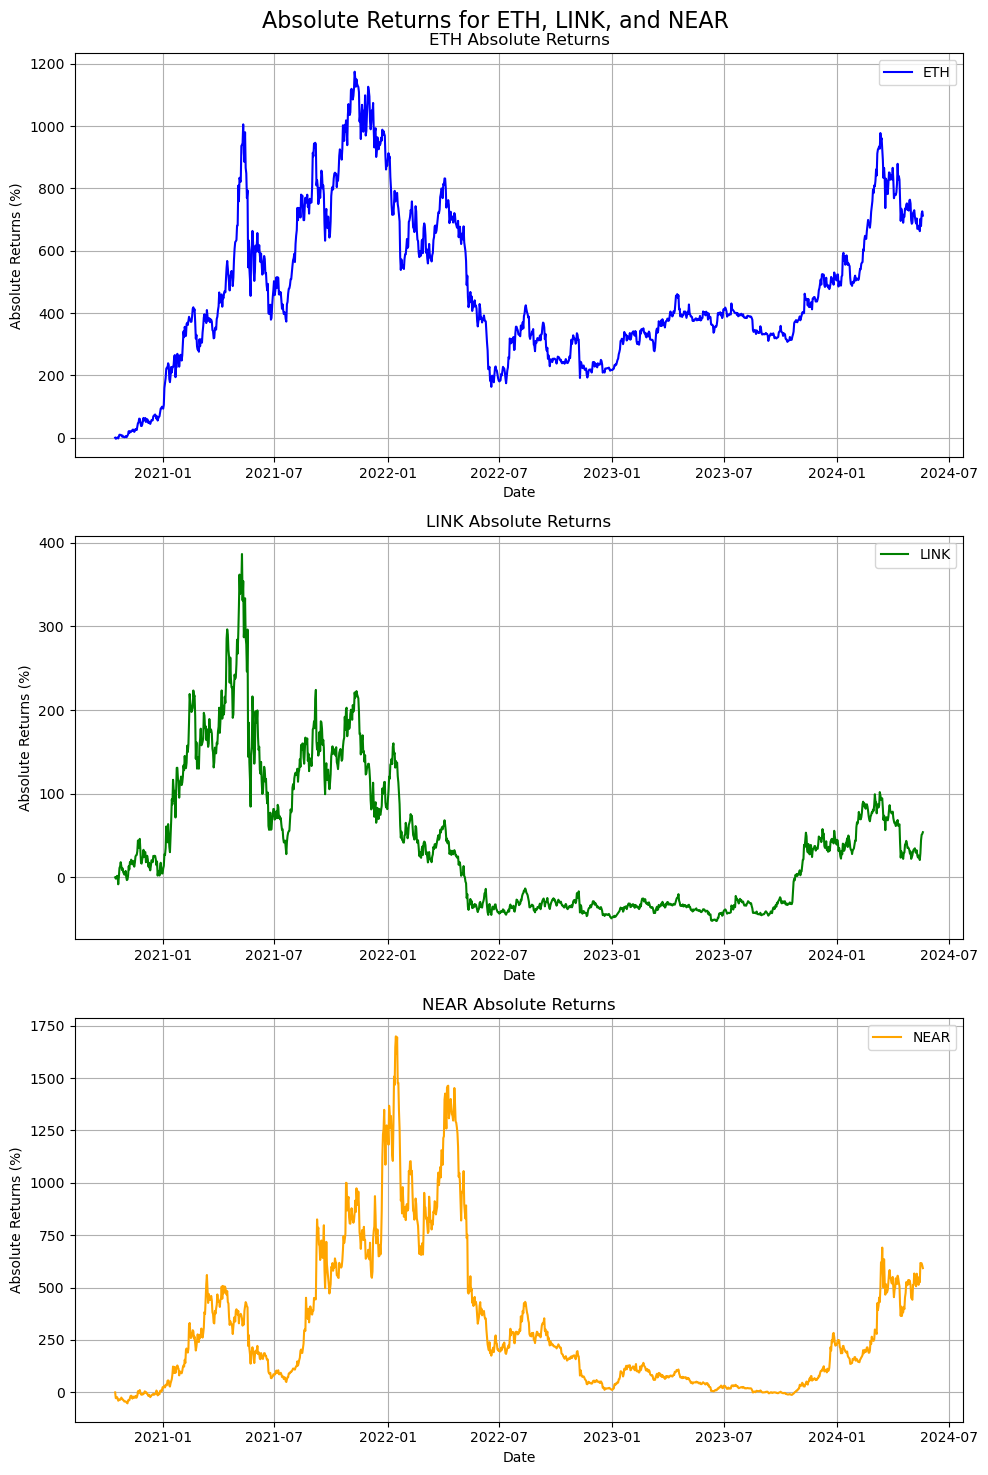

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].plot(eth_abs_ret, label='ETH', color='blue')
axs[0].set_title('ETH Absolute Returns')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Absolute Returns (%)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(link_abs_ret, label='LINK', color='green')
axs[1].set_title('LINK Absolute Returns')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Absolute Returns (%)')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(near_abs_ret, label='NEAR', color='orange')
axs[2].set_title('NEAR Absolute Returns')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Absolute Returns (%)')
axs[2].legend()
axs[2].grid(True)

fig.suptitle('Absolute Returns for ETH, LINK, and NEAR', fontsize=16)
plt.tight_layout()
plt.show()

- **ETH Absolute Returns (Top Chart)**

    - **Growth Pattern**: Ethereum exhibits significant growth in the early period, peaking around early 2022. Thereafter, it shows a sharp decline before stabilizing and then rising again.

    - **Volatility**: The chart reflects high volatility in ETH's price, characterized by sharp increases and equally rapid declines, which is typical for many cryptocurrencies. The returns exceed 1000% at their peak but also drop significantly, showing the high-risk, high-reward nature of this investment.

- **LINK Absolute Returns (Middle Chart)**

    - **Return Pattern**: LINK's returns show a significant peak around mid-2021, reaching nearly 300%. Following this, the returns decline steadily before starting to recover in 2023.

    - **Volatility and Stability**: Similar to ETH, LINK shows volatility but not to the same extreme. The decline phase is more gradual compared to the sharp fluctuations seen in ETH's chart.

- **NEAR Absolute Returns (Bottom Chart)**

    - **Performance Peaks**: NEAR shows multiple peaks throughout the observed period, with the highest peaks surpassing 1500% returns. This suggests moments of extremely high profitability.
    
    - **Comparison to Single Assets**: The volatility in the NEAR is notable but generally appears more contained than in ETH’s returns. This could suggest some level of diversification or active management that tempers the extreme ups and downs typical of single cryptocurrency investments.

### Plotting the Squared Returns

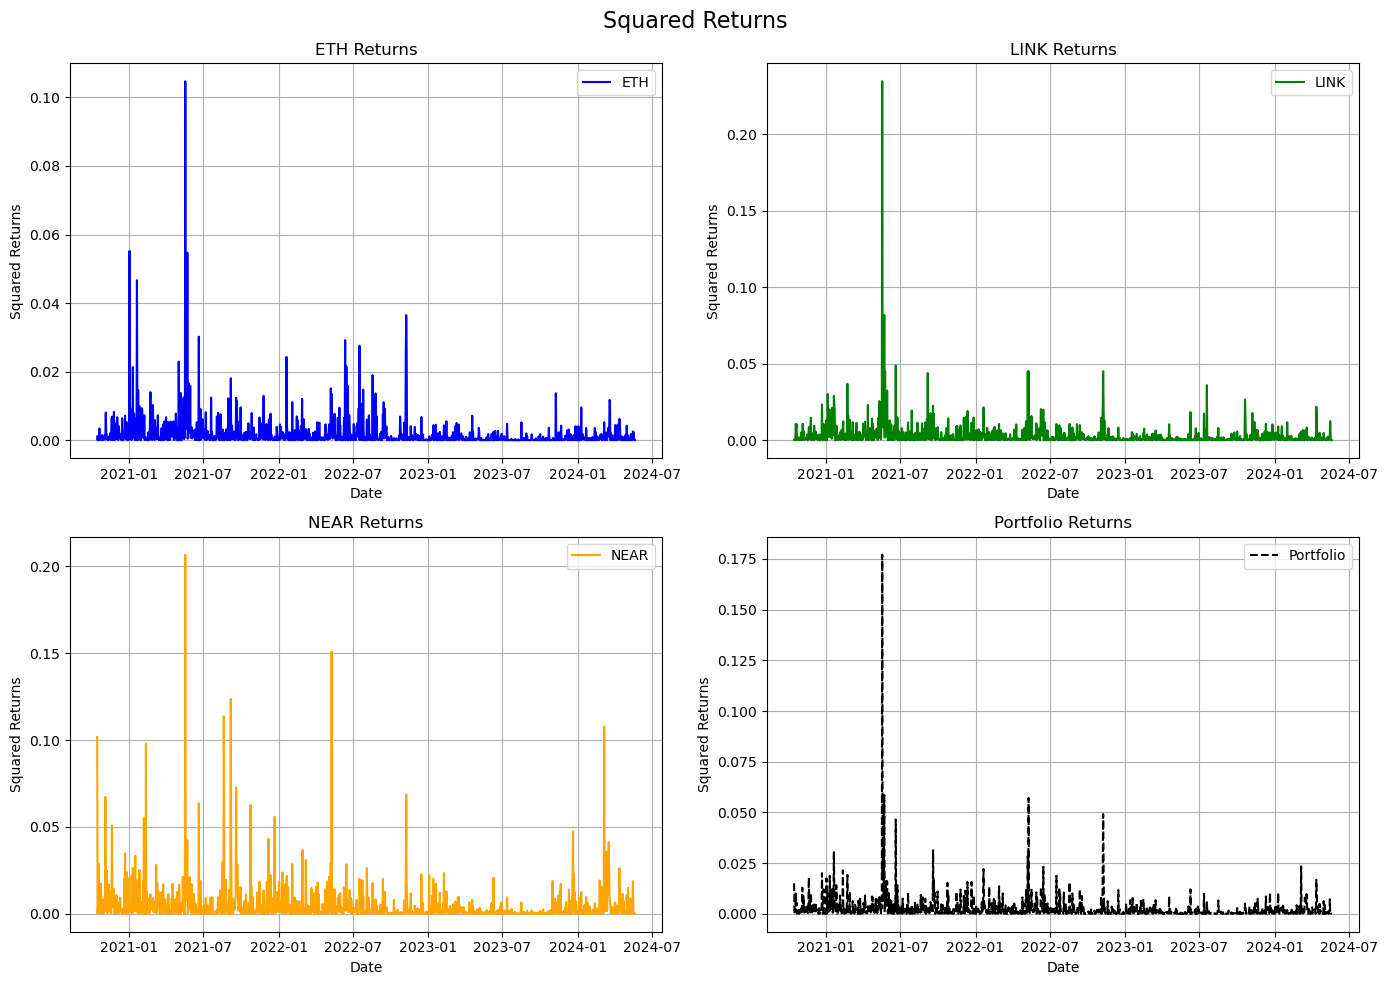

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(eth_sq_ret, label='ETH', color='blue')
axs[0, 0].set_title('ETH Returns')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Squared Returns')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(link_sq_ret, label='LINK', color='green')
axs[0, 1].set_title('LINK Returns')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Squared Returns')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(near_sq_ret, label='NEAR', color='orange')
axs[1, 0].set_title('NEAR Returns')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Squared Returns')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(port_sq_ret, label='Portfolio', linestyle='--', color='black')
axs[1, 1].set_title('Portfolio Returns')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Squared Returns')
axs[1, 1].legend()
axs[1, 1].grid(True)

fig.suptitle('Squared Returns', fontsize=16)
plt.tight_layout()
plt.show()

- **ETH Squared Returns (Top Left)**

    - **Observations**: The ETH chart shows numerous spikes, particularly notable in the early part of the time series. This indicates periods of high volatility, where ETH experienced significant price movements either upwards or downwards.

    - **Implication**: The high spikes in squared returns suggest that ETH investments carry a high risk, with potential for large gains or losses. This is typical for cryptocurrencies, which are known for their unpredictability and sharp price fluctuations.

- **LINK Squared Returns (Top Right)**

    - **Observations**: Similar to ETH, LINK displays several spikes, but with less frequency and intensity. The highest spike is notable around mid-2021.

    - **Implication**: LINK also exhibits considerable volatility, though possibly slightly less than ETH based on the comparative heights of the spikes. Investors in LINK should be prepared for potentially large price swings, though these may occur less frequently than in ETH.

- **NEAR Squared Returns (Bottom Left)**

    - **Observations**: NEAR shows spikes, but these are generally lower and less frequent than those observed in the individual cryptocurrency assets (ETH and LINK). This suggests periods of heightened activity or market movements affecting the portfolio.

    - **Implication**: While still displaying signs of volatility, NEAR appears to manage risk better than the individual cryptocurrency investments. The reduced height and frequency of spikes could indicate effective diversification or risk management strategies.

- **Portfolio Squared Returns (Bottom Right)**

    - **Observations**: This general portfolio shows numerous low-height spikes distributed throughout the observed period, indicating consistent, moderate-level volatility.
    
    - **Implication**: This portfolio appears to be the most stable among those analyzed, with its lower and more consistent spikes suggesting a well-diversified or balanced investment strategy that mitigates high volatility.

### 1.2.2. Descriptive Statistics

In [33]:
desc_stats = df.describe()
desc_stats

,ETH,LINK,NEAR,ret_ETH,ret_LINK,ret_NEAR,ret_port
count,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000
mean,2174.289634,15.094087,4.585600,0.001600,0.000322,0.001476,0.001133
std,941.254026,9.027084,3.860793,0.043288,0.055761,0.069758,0.049349
min,365.410000,5.129000,0.533900,-0.323577,-0.484226,-0.454605,-0.420803
25%,1579.400000,7.169000,1.721000,-0.017972,-0.028947,-0.032892,-0.023634
50%,1890.560000,13.552000,3.236600,0.001537,0.003165,-0.000604,0.002753
75%,2889.080000,20.067000,6.214000,0.023503,0.030264,0.035602,0.028791
max,4814.300000,52.311000,20.183800,0.234909,0.286017,0.351644,0.241884


**Variables:**
- **ETH, LINK, NEAR**: These columns represent the prices of Ethereum (ETH), Chainlink (LINK), and NEAR Protocol (NEAR) over a certain period.
- **ret_ETH, ret_LINK, ret_NEAR**: These columns represent the daily log returns of ETH, LINK, and NEAR, respectively.
- **ret_port**: This column represents the daily return of a portfolio composed of ETH, LINK, and NEAR.
**Statistics**:
- **count**: The number of observations (1313), which indicates the number of daily price and return data points available for each cryptocurrency and the portfolio.
- **mean**: The average value over the observation period.
- **std (standard deviation)**: A measure of the dispersion or volatility of the prices and returns.
- **min**: The minimum value observed.
- **25% (first quartile)**: The value below which 25% of the observations fall.
- **50% (median)**: The middle value of the dataset.
- **75% (third quartile)**: The value below which 75% of the observations fall.
- **max**: The maximum value observed.

Now, i will take the Brownian motion test for the series, consists of:

- **Stationary test**
- **Increments Normality test**
- **Increments Independence test**

### 1.2.3. Stationary

In [34]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

### ACF and PACF approach

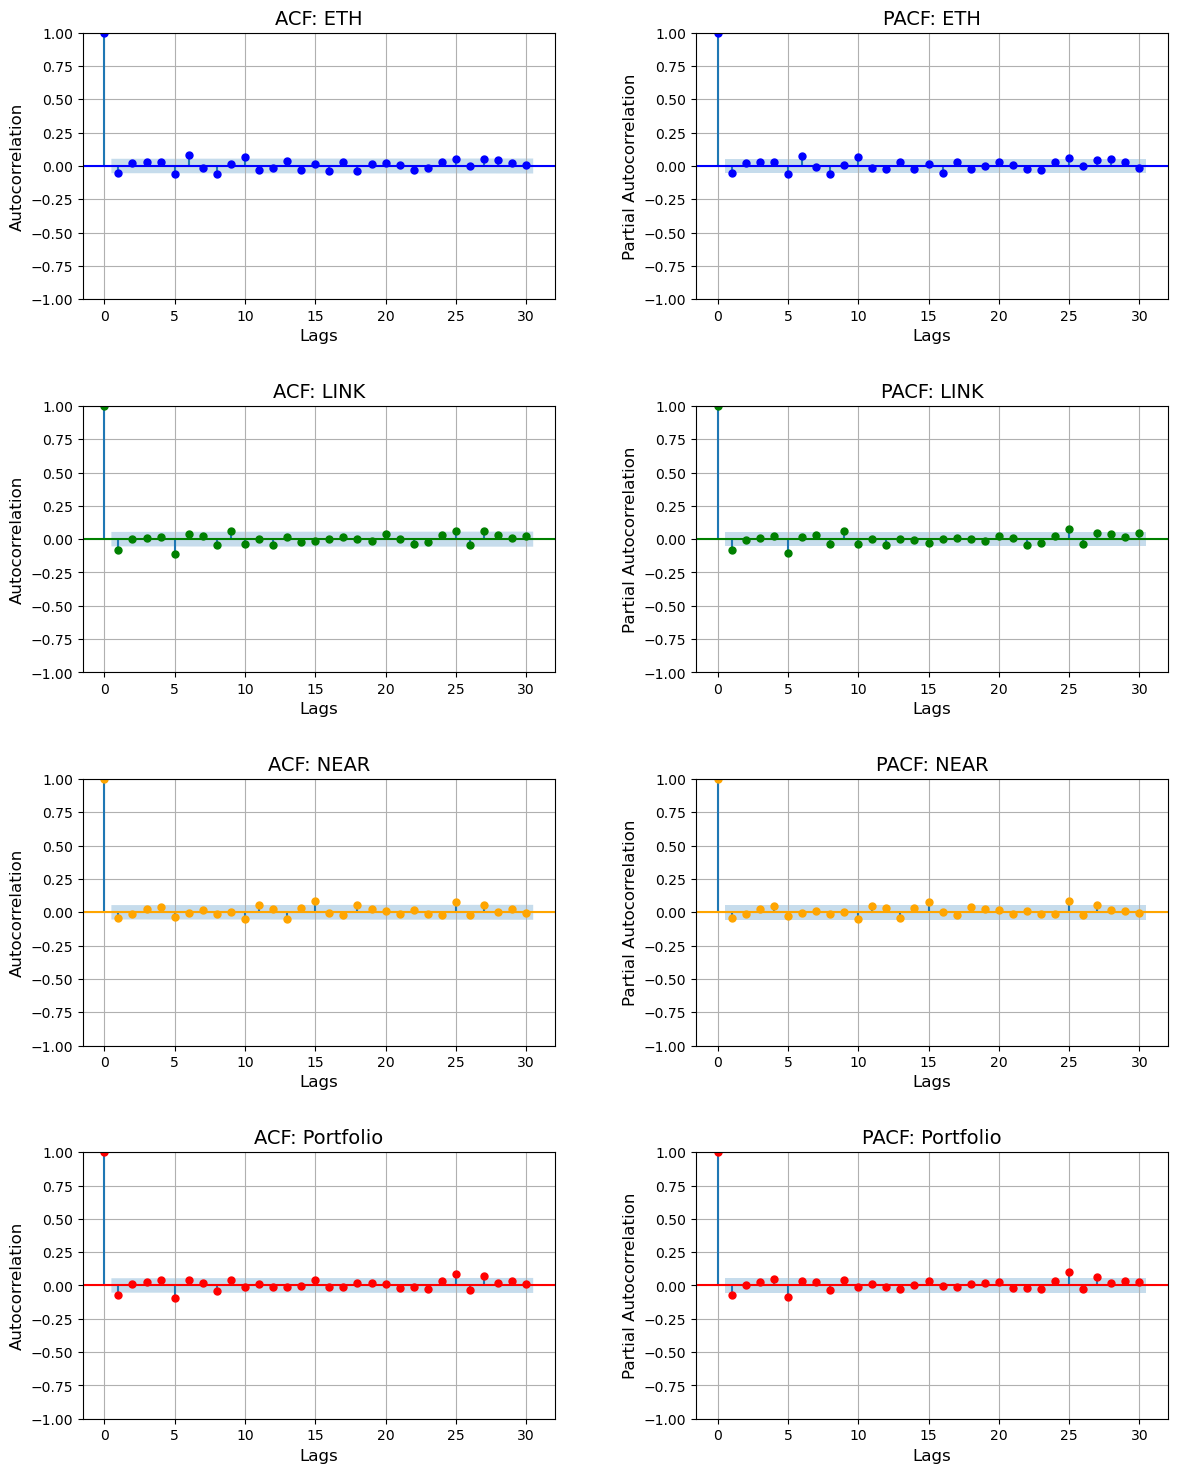

In [35]:
# Number of lags
lags = 30

# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(14, 18))

# Adjust the space between plots
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Function to plot ACF and PACF with enhanced visibility
def plot_acf_pacf(series, lags, ax1, ax2, title, color):
    plot_acf(series, lags=lags, ax=ax1, color=color)
    ax1.set_title(f'ACF: {title}', fontsize=14)
    ax1.set_xlabel('Lags', fontsize=12)
    ax1.set_ylabel('Autocorrelation', fontsize=12)
    ax1.grid(True)

    plot_pacf(series, lags=lags, ax=ax2, color=color)
    ax2.set_title(f'PACF: {title}', fontsize=14)
    ax2.set_xlabel('Lags', fontsize=12)
    ax2.set_ylabel('Partial Autocorrelation', fontsize=12)
    ax2.grid(True)

# ETH
plot_acf_pacf(df['ret_ETH'], lags, axs[0, 0], axs[0, 1], 'ETH', 'blue')

# LINK
plot_acf_pacf(df['ret_LINK'], lags, axs[1, 0], axs[1, 1], 'LINK', 'green')

# NEAR
plot_acf_pacf(df['ret_NEAR'], lags, axs[2, 0], axs[2, 1], 'NEAR', 'orange')

# Portfolio
plot_acf_pacf(df['ret_port'], lags, axs[3, 0], axs[3, 1], 'Portfolio', 'red')

# Show the plots
plt.show()

**Interpretation of ACF and PACF:**
1. **Ethereum (ETH)**

- ACF (ETH): The autocorrelation is significant only at lag 0 (which is always the case as it's the correlation of the series with itself) and rapidly diminishes to near zero for subsequent lags. This pattern suggests that ETH returns are effectively random without significant autocorrelation.

- PACF (ETH): The PACF also exhibits significant correlation at lag 0, with correlations near zero at higher lags, confirming the ACF findings and indicating a lack of predictive patterns in returns based on previous values.

2. **ChainLink (LINK)**
- ACF (LINK): LINK shows a similar pattern to ETH, with the autocorrelation at lag 0 and negligible at other lags, suggesting that LINK returns are also random and exhibit no meaningful autocorrelation.

- PACF (LINK): The PACF for LINK mirrors this with correlations flattening out, indicating that previous returns do not influence future returns in any significant way.

3. **NEAR**
- ACF (NEAR): The ACF pattern for NEAR indicates no significant autocorrelations at higher lags, which suggests that the returns of NEAR do not depend significantly on its past returns.

- PACF (NEAR): The PACF supports this by showing minimal correlation at higher lags, confirming the lack of significant partial autocorrelations that could affect predictability.

4. **Portfolio**
- ACF (Portfolio): This portfolio's ACF shows negligible autocorrelations at all lags beyond the initial, which suggests that the returns are random and independent over time.

- PACF (Portfolio): Consistently, the PACF values are also near zero beyond the initial lag, reinforcing the notion of no significant autocorrelations.

**Conclusions on Stationarity:**

- The quick drop-off in autocorrelation at higher lags across all ACF and PACF plots indicates that **the series are stationary**. This implies that the statistical properties such as mean, variance, and autocorrelation of the series do not depend on the time at which the series is observed. Thus, these financial time series do not exhibit trends or seasonal effects.

### Augmented Dickey Fuller approach

**Null Hypothesis (H₀)**: The time series has a unit root (non-stationary).

**Alternative Hypothesis (H₁)**: The time series does not have a unit root (stationary).

**Interpretation**: 
- If the p-value < 0.05, we reject the null hypothesis and conclude that the series is stationary. 

- If the p-value > 0.05, we fail to reject the null hypothesis and conclude that the series is non-stationary.

In [36]:
results = {}
for col in ['ret_ETH', 'ret_LINK', 'ret_NEAR', 'ret_port']:
    result = adfuller(df[col])
    results[col] = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4],
        '1% Critical Value': result[4]['1%'],
        '5% Critical Value': result[4]['5%'],
        '10% Critical Value': result[4]['10%'],
        'Stationary': None
    }
    
    # Determine stationary based on p-value
    if result[1] < 0.05:
        results[col]['Stationary'] = True
    else:
        results[col]['Stationary'] = False

# Print ADF test results
for col, result in results.items():
    print(f"Stationary Test Results for {col}:")
    print(f"Stationary Statistic: {result['ADF Statistic']}")
    print(f"p-value: {result['p-value']}")
    print(f"Is Stationary? {result['Stationary']}")
    print("\n")

Stationary Test Results for ret_ETH:
Stationary Statistic: -10.804827659494714
p-value: 1.9754789469558814e-19
Is Stationary? True


Stationary Test Results for ret_LINK:
Stationary Statistic: -11.91749724185178
p-value: 5.123726536220889e-22
Is Stationary? True


Stationary Test Results for ret_NEAR:
Stationary Statistic: -38.10246072896749
p-value: 0.0
Is Stationary? True


Stationary Test Results for ret_port:
Stationary Statistic: -16.96299280669181
p-value: 9.27856320077818e-30
Is Stationary? True




## 1.3. Normality test & Indepedence test

### 1.3.1. Normality test (D'Agostino's K-squared Test)

In [37]:
from scipy.stats import normaltest

**Null Hypothesis (H₀)**: The sample data is drawn from a population that follows a normal distribution.

**Alternative Hypothesis (H₁)**: The sample data is not drawn from a population that follows a normal distribution.

**Interpretation**:
- **If p-value > 0.05**: Fail to reject the null hypothesis. Conclude that the sample data is likely drawn from a normally distributed population.

- **If p-value ≤ 0.05**: Reject the null hypothesis. Conclude that the sample data is not likely drawn from a normally distributed population.

In [38]:
# Select only the returns columns for normality tests
returns_columns = ['ret_ETH', 'ret_LINK', 'ret_NEAR', 'ret_port']
returns_data = df[returns_columns]

# Function to perform and print results of normality tests
def perform_normality_tests(data):
    results = {}
    
    for column in data.columns:
        series = data[column].dropna()  # Drop NA values if any
        
        # D'Agostino's K-squared test
        k2_stat, k2_p = normaltest(series)
        
        results[column] = {
            'D\'Agostino\'s K-squared': {'Statistic': k2_stat, 'p-value': k2_p}
        }
    return results

# Perform normality tests on the returns data
normality_results = perform_normality_tests(returns_data)

# Print the results
for column, tests in normality_results.items():
    print(f"\nNormality test results for {column}:")
    
    # # Shapiro-Wilk Test
    # shapiro_test = tests['Shapiro-Wilk']
    # shapiro_p = shapiro_test['p-value']
    # print(f"Shapiro-Wilk Test:")
    # print(f"  Statistic: {shapiro_test['Statistic']}")
    # print(f"  p-value: {shapiro_p}")
    # print(f"Is Normally Distributed? {'Yes' if shapiro_p > 0.05 else 'No'}")
    
    # D'Agostino's K-squared Test
    k2_test = tests['D\'Agostino\'s K-squared']
    k2_p = k2_test['p-value']
    print(f"D'Agostino's K-squared Test:")
    print(f"  Statistic: {k2_test['Statistic']}")
    print(f"  p-value: {k2_p}")
    print(f"Is Normally Distributed? {'Yes' if k2_p > 0.05 else 'No'}")
    
    # # Anderson-Darling Test
    # ad_test = tests['Anderson-Darling']
    # ad_stat = ad_test['Statistic']
    # ad_critical_values = ad_test['Critical Values']
    # ad_significance_levels = ad_test['Significance Level']
    # print(f"Anderson-Darling Test:")
    # print(f"  Statistic: {ad_stat}")
    # for cv, sl in zip(ad_critical_values, ad_significance_levels):
    #     print(f"   Critical Value ({sl}%): {cv}")
    # is_norm_ad = ad_stat < ad_critical_values[2]  # 5% significance level
    # print(f"Is Normally Distributed? {'Yes' if is_norm_ad else 'No'}")


Normality test results for ret_ETH:
D'Agostino's K-squared Test:
  Statistic: 189.98976499913508
  p-value: 5.549408836739819e-42
Is Normally Distributed? No

Normality test results for ret_LINK:
D'Agostino's K-squared Test:
  Statistic: 234.4172515007937
  p-value: 1.2500880543328718e-51
Is Normally Distributed? No

Normality test results for ret_NEAR:
D'Agostino's K-squared Test:
  Statistic: 136.52374302548657
  p-value: 2.260715321354875e-30
Is Normally Distributed? No

Normality test results for ret_port:
D'Agostino's K-squared Test:
  Statistic: 277.6724933389596
  p-value: 5.060392265683531e-61
Is Normally Distributed? No


### 1.3.2. Independence test (Ljung-Box test)

**Null Hypothesis (H₀)**: There is no autocorrelation in the time series at the specified lag.

**Alternative Hypothesis (H₁)**: There is autocorrelation in the time series at the specified lag.

**Interpretation**:
- **If p-value ≤ 0.05**: Reject the null hypothesis. Conclude that there is significant autocorrelation in the time series at the specified lag.

- **If p-value > 0.05**: Fail to reject the null hypothesis. Conclude that there is no significant autocorrelation in the time series at the specified lag.

In [39]:
# Columns to perform Ljung-Box test on
columns_to_test = ['ret_ETH', 'ret_LINK', 'ret_NEAR', 'ret_port']

# Dictionary to store Ljung-Box test results
lb_test_results = {}

# Perform Ljung-Box test for each column
for col in columns_to_test:
    lb_test = sm.stats.acorr_ljungbox(df[col], lags=[20], return_df=True)
    lb_test_results[col] = lb_test

# Print or inspect Ljung-Box test results
for col, lb_test in lb_test_results.items():
    print(f"Ljung-Box test results for {col}:")
    print(lb_test)
    print()

    # Extract p-value for easier interpretation
    p_value = lb_test.iloc[0, 1]

    if p_value <= 0.05:
        print(f"There is no significant autocorrelation in {col} at lag 20 (p-value: {p_value:.4f}).")
    else:
        print(f"There is significant autocorrelation in {col} at lag 20 (p-value: {p_value:.4f}).")

Ljung-Box test results for ret_ETH:
      lb_stat  lb_pvalue
20  42.418141   0.002439

There is no significant autocorrelation in ret_ETH at lag 20 (p-value: 0.0024).
Ljung-Box test results for ret_LINK:
      lb_stat  lb_pvalue
20  44.836812   0.001161

There is no significant autocorrelation in ret_LINK at lag 20 (p-value: 0.0012).
Ljung-Box test results for ret_NEAR:
      lb_stat  lb_pvalue
20  35.102201   0.019567

There is no significant autocorrelation in ret_NEAR at lag 20 (p-value: 0.0196).
Ljung-Box test results for ret_port:
      lb_stat  lb_pvalue
20  33.107638   0.032834

There is no significant autocorrelation in ret_port at lag 20 (p-value: 0.0328).


**From the results of the Stationary, Normality, and Independence test, we can conclude that data has Brownian motion as the series are stationary, increments non-normal, and independent**

# Question 2

## 2.1. Estimate EWMA, GARCH(1,1), and GJR-GARCH(1,1,1) with t distribution

### EWMA model

As there is no library for estimating EWMA model to retrieve the AIC and BIC, therefore i manually create a function to estimate the model to get those needed paramaters.
- You can also find all the models that i build manually in the **model.py** file within the **EWMA OOP/Class**

In [40]:
def EWMA(sq_rets, lam):
    '''
    Calculates the Exponentially Weighted Moving Average (EWMA) volatility for a series of squared returns.

    Parameters:
    sq_rets (pd.Series): A pandas Series of squared returns.
    lam (float): The smoothing parameter (lambda), between 0 and 1.

    Returns:
    pd.Series: A pandas Series of the annualized EWMA volatility with the same index as sq_rets.
    '''
    sq_ret = sq_rets.values
    EWMA_var = np.zeros(len(sq_ret))
    EWMA_var[0] = sq_ret[0]  # set initial variance based on the first squared return

    for r in range(1, len(sq_ret)):
        EWMA_var[r] = (1-lam)*sq_ret[r] + lam*EWMA_var[r-1] # compute EWMA variance

    EWMA_vol = np.sqrt(EWMA_var*365) 
    return pd.Series(EWMA_vol, index=sq_rets.index, name='EWMA Vol {}'.format(lam))

def compute_log_likelihood(residuals):
    '''
    Computes the log-likelihood of a set of residuals assuming they are normally distributed.

    Parameters:
    residuals (np.ndarray or pd.Series): An array or Series of residuals.

    Returns:
    float: The log-likelihood of the residuals.
    '''
    N = len(residuals) # number of residuals
    sigma2 = np.var(residuals) # variance of the residuals
 
    # the log-likelihood formula for normally distributed residuals
    log_likelihood = -0.5 * N * np.log(2 * np.pi) - 0.5 * N * np.log(sigma2) - (0.5 / sigma2) * np.sum(residuals ** 2)

    return log_likelihood

def calculate_aic_bic(log_likelihood, N, k=1):
    '''
    Calculates the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC).

    Parameters:
    log_likelihood (float): The log-likelihood value.
    N (int): The number of observations.
    k (int, optional): The number of parameters estimated (default is 1).

    Returns:
    tuple: AIC and BIC values.
    '''

    # AIC formula: 2*k - 2*log_likelihood
    AIC = 2 * k - 2 * log_likelihood

    # BIC formula: k*log(N) - 2*log_likelihood
    BIC = k * np.log(N) - 2 * log_likelihood
    
    return AIC, BIC

In [41]:
# Estimate the model
ewma94_port = EWMA(port_sq_ret, 0.94) # compute EWMA with lambda = 0.94
residuals_port = df['ret_port']/ewma94_port # compute residuals
log_likelihood_port = compute_log_likelihood(residuals_port.dropna()) # compute the log-likelihood of the residuals
N_port = residuals_port.dropna().shape[0] # number of observations in the residuals
aic_ewma, bic_ewma = calculate_aic_bic(log_likelihood_port, N_port) # compute AIC and BIC

print(f"Portfolio AIC: {aic_ewma}, BIC: {bic_ewma}")

Portfolio AIC: -4167.370813766129, BIC: -4162.190743891826


**Interpretation:**

- Both the AIC and BIC values are negative. In the context of these criteria, lower (or more negative) values indicate a better fit of the model to the data.

- Negative values suggest that the model fits the data extremely well since the log-likelihood is very high (less negative), leading to a very large negative value when the penalty terms are subtracted.


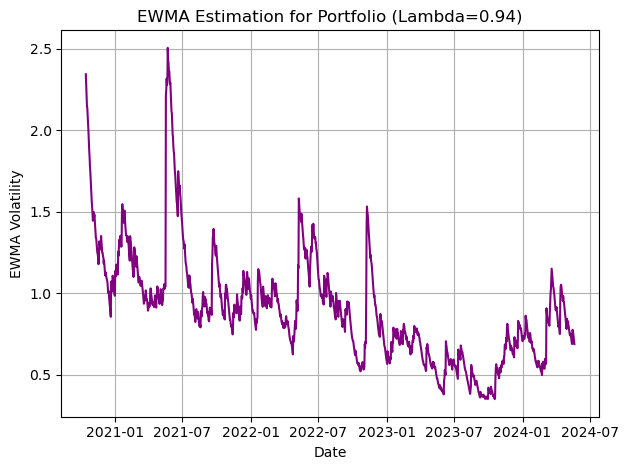

In [42]:
# plot the model results
plt.plot(ewma94_port, label='PORT', linestyle='-', color='purple')
plt.title('EWMA Estimation for Portfolio (Lambda=0.94)')
plt.xlabel('Date')
plt.ylabel('EWMA Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpret the EWMA model result:**

- **Initial Peaks**: Early in the series (early 2021), there are high peaks in volatility, suggesting significant fluctuations in portfolio returns during this period. These might be due to market events or changes in the assets held within the portfolio.

- **General Decline in Volatility**: Over time, there is a noticeable downward trend in the volatility estimation, indicating that the portfolio's returns have become more stable. This decreasing trend could be the result of strategic changes in portfolio management, such as diversification or changes in asset allocation.

- **Recent Trends**: Towards the current date (mid-2024), there appears to be a slight increase in volatility again. This uptick could suggest a response to recent market conditions or adjustments within the portfolio that have introduced more risk.

### GARCH(1,1) model

In [43]:
from arch import arch_model

# function to estimate GARCH(1,1) model with t-distributed errors
def estimate_garch_t(df, series_name):

    # specify GARCH(1,1) model with t-distributed errors
    model = arch_model(df[series_name], vol='Garch', p=1, q=1, dist='t')
    
    # fit the model
    model_fit = model.fit(disp='off')
    
    return model_fit

print(f"Estimating GARCH(1,1) with t-distribution for portfolio")
model_fit_garch = estimate_garch_t(df, 'ret_port')
print(model_fit_garch.summary())

Estimating GARCH(1,1) with t-distribution for portfolio
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                     ret_port   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                2233.05
Distribution:      Standardized Student's t   AIC:                          -4456.11
Method:                  Maximum Likelihood   BIC:                          -4430.21
                                              No. Observations:                 1313
Date:                      Sat, May 25 2024   Df Residuals:                     1312
Time:                              22:36:40   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------

**GARCH(1,1) interpretation:**

**Mu (μ)**: The mean return of the portfolio is estimated to be 0.0021105 (or 0.21105% per period), with a standard error of 0.001045. The t-value is 2.020, and the p-value is 0.04338, indicating that the mean return is statistically significant at the 5% level (since p < 0.05).

**Omega (ω)**: This is the constant or long-run average variance component of the model, estimated at 0.000026567. It is statistically significant with a p-value of 0.03062.

**Alpha[1] (α₁)**: Estimated at 0.0733, this parameter measures the reaction of volatility to previous squared innovations (lagged error terms squared). It's statistically significant, suggesting that past shocks have a noticeable effect on current volatility.

**Beta[1] (β₁)**: At 0.9192, beta measures the persistence of past volatility. The closer this value is to 1, the more persistent the volatility. The very high t-value and a p-value of 0.000 confirm its significance, indicating that volatility shocks are highly persistent.

**Nu (ν)**: The degrees of freedom of the t-distribution are estimated at 5.4210, suggesting heavy tails in the distribution of returns. This parameter is significantly different from normality (which would require infinite degrees of freedom), as indicated by the very low p-value (1.19e-11). This implies that extreme values are more likely than would be predicted by a normal distribution.

**Log-Likelihood**: The log-likelihood value is 2233.05, which helps in assessing the goodness of fit of the model. Higher values indicate a better fit.

**AIC and BIC**: The Akaike Information Criterion (-4456.11) and Bayesian Information Criterion (-4430.21) are both relatively low, suggesting that the model is adequately capturing the dynamics in the data without being overly complex.

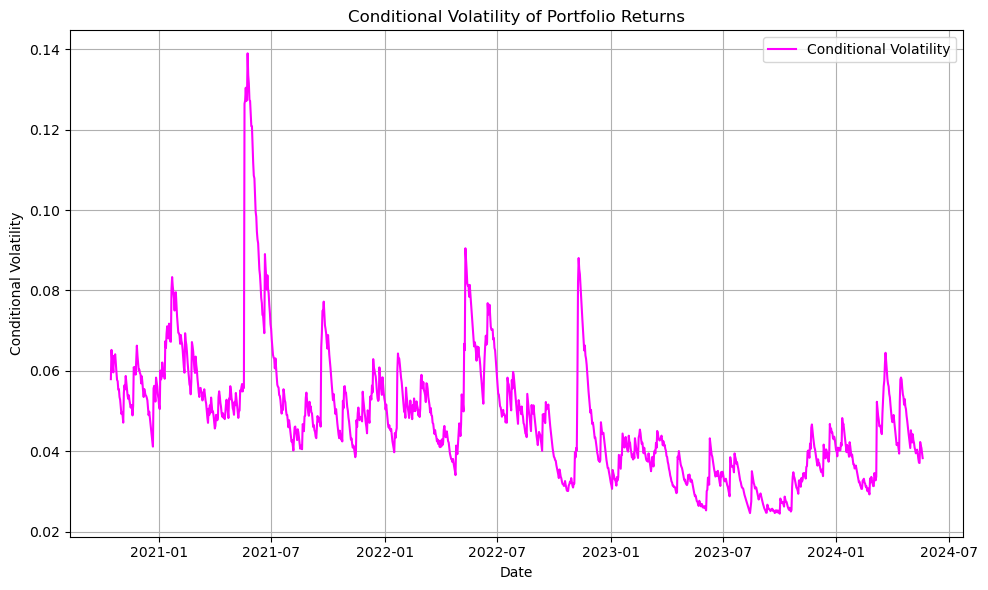

In [67]:
# Get the conditional volatility (square root of variance)
conditional_volatility = model_fit_garch.conditional_volatility

plt.figure(figsize=(10, 6))
plt.plot(conditional_volatility, label='Conditional Volatility', color='magenta')
plt.title('Conditional Volatility of Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Fluctuations in Volatility:**

- The conditional volatility exhibits significant fluctuations over time. It reaches peaks at certain points, indicating periods of high market uncertainty or specific events affecting portfolio volatility.

- The highest peak appears around early 2022, with other noticeable spikes occurring periodically. Such spikes could be tied to market events, portfolio rebalancing, changes in asset allocations, or macroeconomic announcements.

**Trend Over Time:**

- The overall trend in volatility shows a decrease from early 2021 through mid-2024. This descending trend suggests that the portfolio's risk level, in terms of return variability, has generally decreased over time.

- The trend towards decreasing volatility could indicate effective risk management strategies, changes in the underlying assets that compose the portfolio, or a more stable market environment in the later period.

**Periods of Increased Volatility:**

- The graph shows several periods where volatility sharply increases. These periods of heightened volatility are critical for risk management, as they represent increased uncertainty and risk in the portfolio.

- Portfolio managers might use this information to adjust their strategies, possibly by hedging against expected risks during these volatile periods or reconsidering their asset allocation to reduce potential losses.

In [45]:
# Print AIC and BIC
print(f"AIC: {model_fit_garch.aic}")
print(f"BIC: {model_fit_garch.bic}")

AIC: -4456.108515494687
BIC: -4430.208166123173


**GARCH(1,1) model compared with EWMA:**

**Lower AIC and BIC Values:**

- Both the AIC and BIC for the GARCH(1,1) model are lower (more negative) than those for the EWMA model.

- AIC: The GARCH(1,1) model's AIC of -4456.108515494687 is lower than the EWMA model's AIC of -4167.370813766129.

- BIC: The GARCH(1,1) model's BIC of -4430.208166123173 is lower than the EWMA model's BIC of -4162.190743891826.

**Model Comparison**:

- Since the GARCH(1,1) model has lower AIC and BIC values than the EWMA model, it suggests that the GARCH(1,1) model provides a better fit to the data while adequately accounting for model complexity.

### GJR-GARCH(1,1,1) model

In [46]:
from contextlib import redirect_stderr
import os

# Initialize the results variable
results_gjr = None

# Create a dummy file object to redirect stderr to
class DummyFile(object):
    def write(self, x): pass

# Suppress warnings context manager
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=Warning)  # Ignore all warnings

    # Redirect stderr to suppress optimizer warnings
    with redirect_stderr(DummyFile()):
        # Fit GJR-GARCH(1,1,1) model with Student's t distribution
        try:
            returns = df[['ret_port']].dropna()
            model = arch_model(returns, vol='Garch', p=1, q=1, o=1, dist='StudentsT')  # Specify 'StudentsT' distribution
            results_gjr = model.fit(disp='off', options={'maxiter': 100, 'ftol': 1e-6, 'gtol': 1e-6})

        except Exception as e:
            # Handle specific warnings or exceptions here if needed
            print(f"Exception occurred during model fitting: {e}")

# Print results summary if fitting was successful
if results_gjr is not None:
    print(results_gjr.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                     ret_port   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                2234.99
Distribution:      Standardized Student's t   AIC:                          -4457.99
Method:                  Maximum Likelihood   BIC:                          -4426.91
                                              No. Observations:                 1313
Date:                      Sat, May 25 2024   Df Residuals:                     1312
Time:                              22:36:42   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

**GJR-GARCH(1,1,1) model results:**

- Log-Likelihood: The log-likelihood of 2234.99 indicates how well the model fits the data, with higher values suggesting a better fit.
AIC/BIC: Both the AIC (-4457.99) and BIC (-4426.91) are provided to assess model fit with penalties for the number of parameters used. Lower values are preferred, indicating a better model fit relative to the complexity.

**Mu (μ):**

- Estimate: 0.002354 or 0.2354%, suggesting the average return per period.

- Standard Error: 0.001032, providing a measure of the estimate's precision.

- T-statistic: 2.254 and p-value: 0.0422, indicating that the mean return is statistically significant at the 5% level (p < 0.05). This suggests that the mean return is different from zero.

**Omega (ω):**

- Estimate: 0.000015913, which is the baseline variance component when no shocks have occurred.

- Standard Error: 0.000005352, and p-value: 0.002947, making it statistically significant. This parameter is crucial as it forms the foundation of the conditional variance equation.

**Alpha (α₁):**

- Estimate: 0.0869, measuring the impact of past squared shocks on current volatility.

- Standard Error: 0.02458, with a p-value: 0.000104, indicating strong statistical significance. This suggests that past shocks significantly increase future volatility.

**Gamma (γ₁):**

- Estimate: -0.0429, showing the additional impact on volatility from negative shocks.

- Standard Error: 0.01998, and a p-value: 0.03107. The negative sign and statistical significance suggest that negative shocks decrease volatility, which is unusual as typically, negative shocks are expected to increase volatility (leverage effect). This might indicate a unique market or asset behavior or potential data or model specification issues.

**Beta (β₁):**

- Estimate: 0.9336, reflects the persistence of volatility shocks.

- Standard Error: 0.01792, with a p-value: 0.000, strongly indicating that previous periods' volatility strongly influences current volatility.

**Nu (ν):**

- Estimate: 5.3545, defining the degrees of freedom for the Student's t-distribution, suggesting fat tails.

- Standard Error: 0.786, and a very significant p-value: 9.37e-12, confirming that the return distribution significantly deviates from normality, indicative of higher kurtosis (more extreme values than the normal distribution would predict).

**Overall, the GJR-GARCH model seems well-fitted with significant parameters that are theoretically important for capturing volatility clustering and leverage effects in financial time series data.**

In [47]:
# Extract AIC and BIC
print(f"AIC: {results_gjr.aic}")
print(f"BIC: {results_gjr.bic}")

AIC: -4457.987804011755
BIC: -4426.907384765937


**EWMA Model:**

AIC: -4167.370813766129

BIC: -4162.190743891826

**GARCH(1,1) Model with t-distribution:**

AIC: -4456.108515494687

BIC: -4430.208166123173

**GJR-GARCH(1,1,1) Model with t-distribution:**

AIC: -4457.987804011755

BIC: -4426.907384765937

- Comments on AIC: The GJR-GARCH(1,1,1) model has the lowest AIC value of -4457.987804011755, which suggests it has the best fit among the three models considered.

- Comments on BIC: The GARCH(1,1) model has a slightly lower BIC value (-4430.208166123173) compared to the GJR-GARCH(1,1,1) model (-4426.907384765937). This suggests that, while the GJR-GARCH model provides a marginally better fit (according to AIC), the GARCH(1,1) model might be preferred when penalizing for the number of parameters.

**Conclusion:**

**Best Fit: The GJR-GARCH(1,1,1) model, with the lowest AIC.**


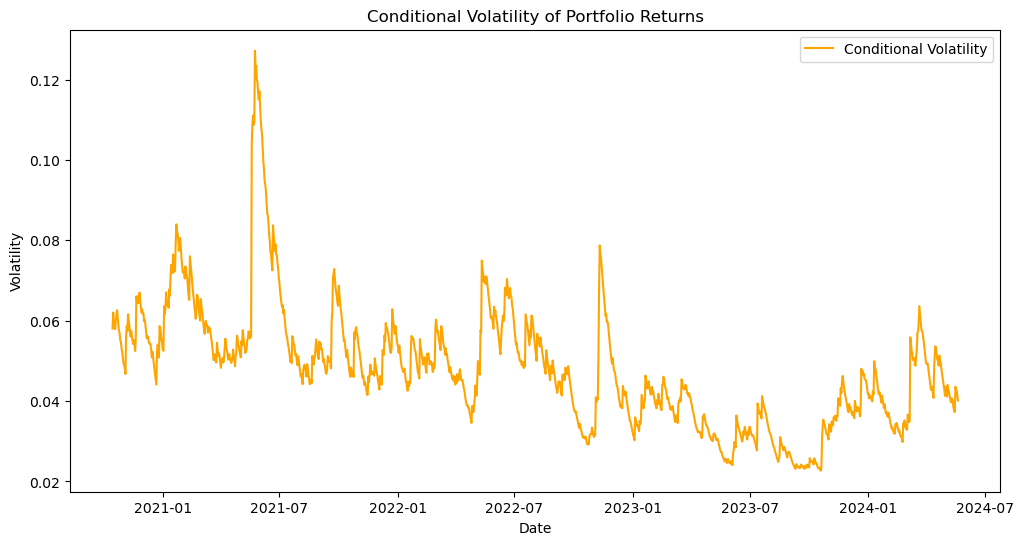

In [65]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(results_gjr.conditional_volatility, label='Conditional Volatility', color='orange')
ax.set_title('Conditional Volatility of Portfolio Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.legend()
plt.show()

**Volatility Peaks:**

- Observation: The chart shows several distinct peaks, with notable spikes around mid-2021, early 2022, and early 2023. These peaks represent periods of high market uncertainty or specific events that have significantly impacted portfolio volatility.

**Trend and Mean Reversion:**

- Observation: Apart from the peaks, the volatility tends to revert to a lower, more stable level. There's a noticeable trend of mean reversion in volatility, where it spikes but eventually falls back to a baseline level.

**Periods of Lower Volatility:**

- Observation: Between the peaks of high volatility, there are extended periods where volatility remains relatively stable and lower, especially noticeable in late 2023 to mid-2024.

### 2.2.Select the best model among EWMA, GARCH(1,1), GJR-GARCH(1,1,1)

**Retest to check the best fit model**

In [49]:
# Absolute AIC values for each model
aic_values = {
    'EWMA': aic_ewma,
    'GARCH(1,1)': model_fit_garch.aic,
    'GJR-GARCH(1,1,1)': results_gjr.aic
}

# Absolute BIC values for each model
bic_values = {
    'EWMA': bic_ewma,
    'GARCH(1,1)': model_fit_garch.bic,
    'GJR-GARCH(1,1,1)': results_gjr.bic
}

# Find the model with the lowest absolute AIC
best_model_abs_aic = min(aic_values, key=aic_values.get)
best_abs_aic_value = aic_values[best_model_abs_aic]

# Find the model with the lowest absolute BIC
best_model_abs_bic = min(bic_values, key=bic_values.get)
best_abs_bic_value = bic_values[best_model_abs_bic]

# Print the results
print(f"The best model based on AIC is: {best_model_abs_aic}")
print(f"The best model based on BIC is: {best_model_abs_bic}")


The best model based on AIC is: GJR-GARCH(1,1,1)
The best model based on BIC is: GARCH(1,1)


**The best fit model is GJR-GARCH(1,1,1)**

- Now, i will conduct the VaR backtesting on the GJR-GARCH(1,1,1)

### 2.3. VaR Backtesting for GJR-GARCH(1,1,1)

Number of violations: 63
Expected violations (at 5.0%): 65.65
P-value (Kupiec's test): 0.6313976401468797


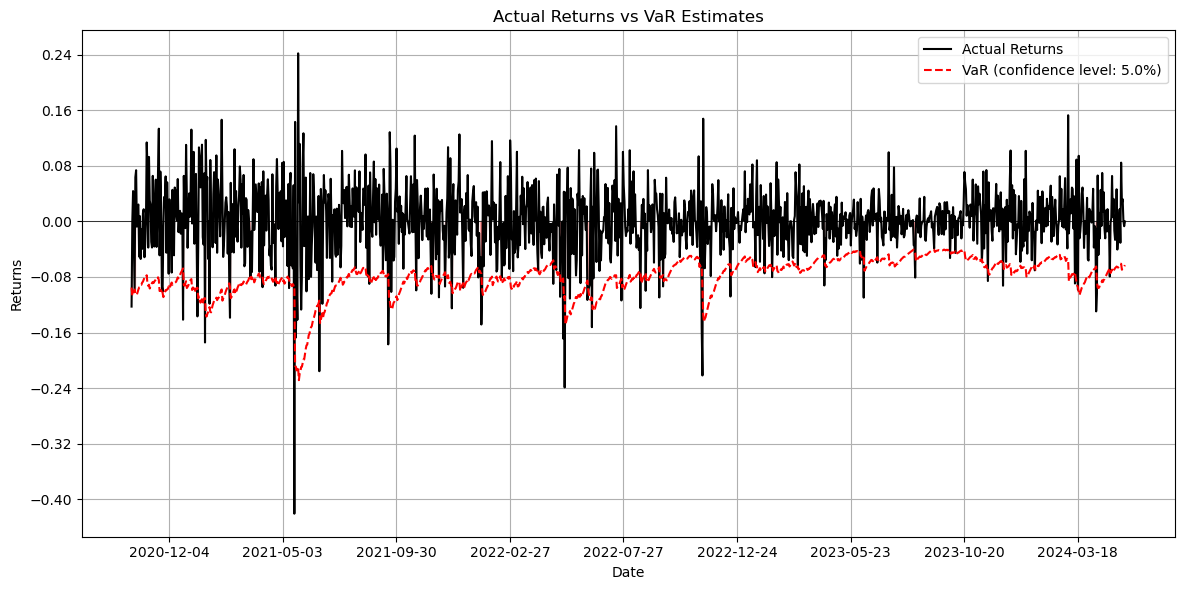

In [64]:
from scipy.stats import norm

returns = pd.Series(df['ret_port'].dropna())

conditional_volatility = pd.Series(model_fit_garch.conditional_volatility.dropna())

# Set confidence level for VaR
confidence_level = 0.05  # 5% VaR

# Calculate VaR using the GJR-GARCH model estimates
VaR = norm.ppf(confidence_level) * conditional_volatility

# Compare actual returns with VaR estimates
violations = returns < VaR

# Calculate backtesting metrics
n_obs = len(returns)
n_violations = np.sum(violations)
expected_violations = n_obs * confidence_level

# Binomial test for backtesting (Kupiec's test)
p_value = 1 - norm.cdf((n_violations - expected_violations) / np.sqrt(expected_violations * (1 - confidence_level)))

# Print backtesting results
print(f"Number of violations: {n_violations}")
print(f"Expected violations (at {confidence_level*100}%): {expected_violations}")
print(f"P-value (Kupiec's test): {p_value}")

plt.figure(figsize=(12, 6))
plt.plot(returns, label='Actual Returns', color='black')
plt.plot(VaR, label=f'VaR (confidence level: {confidence_level*100}%)', color='r', linestyle='--')
plt.fill_between(returns.index, 0, VaR, where=violations, interpolate=True, color='red', alpha=0.3)
plt.title('Actual Returns vs VaR Estimates')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(loc = 'upper right')
plt.grid(True)
plt.tight_layout()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(10))
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

**Analysis of GJR-GARCH(1,1,1) Backtesting Results:**

- **Number of Violations**: There were 63 violations observed, where the actual losses exceeded the VaR estimate.

- **Expected Violations**: At a 5% confidence level, the model would expect 65.65 violations theoretically. This is calculated based on the total number of observations and the VaR confidence level.

- **Model Performance on Kupiec's test**: The p-value from Kupiec's test is 0.6314. Kupiec’s test is used to assess the accuracy of the VaR model by comparing the expected number of violations with the observed number. A high p-value (typically greater than 0.05) indicates that there is no significant evidence to reject the hypothesis that the model is correct. In this case, the p-value of 0.6314 suggests that your VaR model fits well within the expected tolerance levels for violations, meaning it is performing appropriately and does not significantly underpredict risk.

**Conclusion**:

***The GJR-GARCH(1,1,1) model appears to be performing adequately in predicting the risk of your portfolio, as indicated by the number of violations being very close to the expected number, and the p-value being comfortably high. This suggests the model's estimations are reliable according to the backtesting results.***

# Question 3

**As in notebook, we can not implement the BEKK, ADCC,... model using the arch library as like in Google Colab, therefore i will write my own function to estimate each of the model (BEKK, ADCC, DCC, cDCC)**

- ***You can find the models in each of the class/OOP in the mgarch_model.py file that i have submitted***


In [51]:
from mgarch_model import BEKK, ADCC, DCC, cDCC

In [52]:
returns_data = df['ret_port'].values

### BEKK model

In [55]:
bekk_model = BEKK(returns_data)
bekk_model.fit()
bekk_model.print_results()

Estimated Omega:
[[-0.29]]
Estimated A:
[[-0.57]]
Estimated B:
[[-0.9]]
Log-Likelihood: 1101.0551110584097
AIC: -2196.1102221168194
BIC: -2180.570012493911


**BEKK model results interpretation:**

- Omega (Ω): The baseline volatility is estimated at -0.29, indicating a stable underlying level of variance in the data.

- A Matrix: An estimate of -0.57 is unusual as it suggests that increases in past volatility might lead to decreases in future volatility, which is counterintuitive. This could imply issues with the data or model specification.

- B Matrix: The estimate of -0.9 indicates dramatical persistence of past volatility into the future, which is a typical finding in financial time series.

- Model Fit and Metrics: The model shows a good fit to the data with a high log-likelihood value of 1101.05. Both the AIC and BIC values are highly negative, suggesting a well-specified model that effectively balances model complexity with fit.

**Overall, the model fits well according to the metrics but the negative value in the A matrix should be investigated further to ensure the model’s accuracy and reliability. This might involve re-evaluating the data or model assumptions.**

Number of violations: 1259
Expected violations (at 5.0% confidence level): 65.65
P-value (Kupiec's test): 0.0


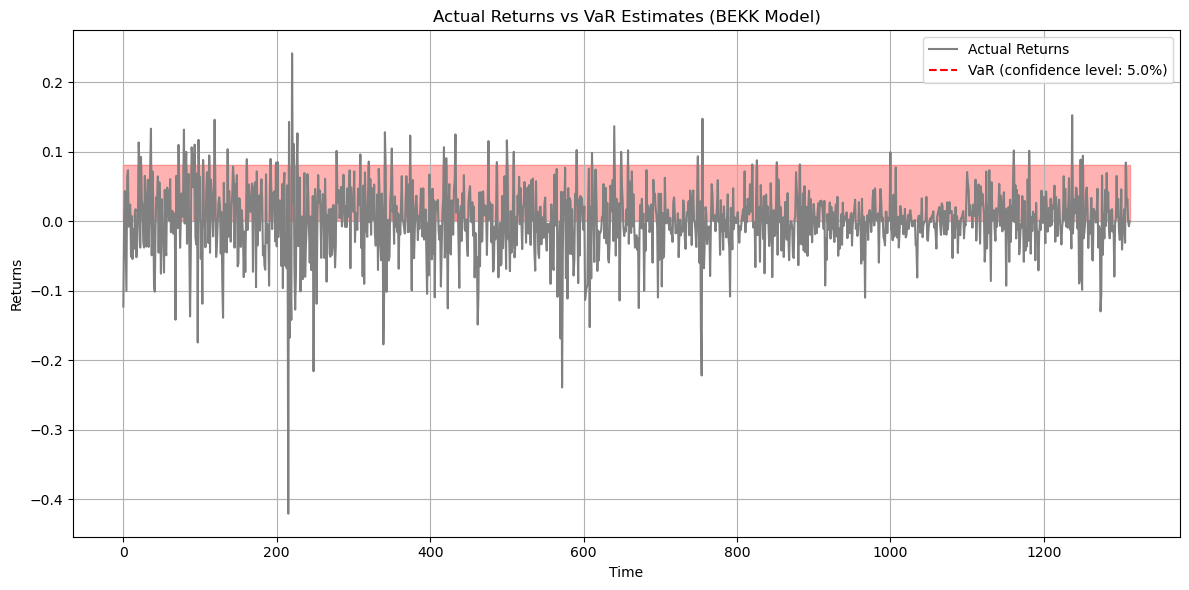

In [56]:
alpha = 0.05
VaR = bekk_model.calculate_var(alpha)

# Backtesting logic
violations = returns_data < VaR
n_obs = len(returns_data)
n_violations = np.sum(violations)
expected_violations = n_obs * alpha

# Calculate p-value using Kupiec's test
p_value = 1 - norm.cdf((n_violations - expected_violations) / np.sqrt(expected_violations * (1 - alpha)))

print(f"Number of violations: {n_violations}")
print(f"Expected violations (at {alpha*100}% confidence level): {expected_violations}")
print(f"P-value (Kupiec's test): {p_value}")

plt.figure(figsize=(12, 6))
plt.plot(returns_data, label='Actual Returns', color='gray')
plt.plot(VaR, label=f'VaR (confidence level: {alpha*100}%)', color='red', linestyle='--')
plt.fill_between(range(len(returns_data)), 0, VaR, where=violations, interpolate=True, color='red', alpha=0.3)
plt.title('Actual Returns vs VaR Estimates (BEKK Model)')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

**BEKK VaR Backtesting results**

- Number of Violations: There were 1259 violations where actual returns exceeded the VaR estimates, suggesting more frequent and severe losses than expected.

- Expected Violations: The expected number of violations for a correctly specified model would be around 65.65, based on a 5% VaR level and the total number of observations.

- Kupiec's Test P-value: With a p-value of 0.0, the test strongly rejects the hypothesis that the model is correctly capturing the risk, indicating that the VaR model underestimates the risk significantly.

**The BEKK model used for estimating VaR does not perform well in accurately capturing the tail risk of the portfolio, as evidenced by the much higher than expected number of violations and the results of Kupiec’s test. This suggests a need for re-evaluating the model specifications or considering alternative models to better capture the risk dynamics of the portfolio.**

### DCC model

In [57]:
dcc_model = DCC(returns_data)
omega_est, alpha_est, beta_est, neg_log_likelihood = dcc_model.fit()

# Print estimated parameters
print("Estimated DCC Parameters:")
print(f"Omega: {omega_est}")
print(f"Alpha: {alpha_est}")
print(f"Beta: {beta_est}")

# Print log-likelihood value
print(f"Log-Likelihood: {-neg_log_likelihood}")

# Compute AIC and BIC
k_dcc = 3  # Number of parameters in DCC model (omega, alpha, beta)
aic_dcc = -2 * neg_log_likelihood + 2 * k_dcc
bic_dcc = -2 * neg_log_likelihood + k_dcc * np.log(dcc_model.T)

print(f"AIC: {aic_dcc}")
print(f"BIC: {bic_dcc}")

Estimated DCC Parameters:
Omega: 0.1
Alpha: 0.1
Beta: 0.8
Log-Likelihood: 453.028611563467
AIC: 912.057223126934
BIC: 927.5974327498424


**DCC model results interpretation:**

- Omega (Ω): Set at 0.1, represents the baseline variance level in the model. It initializes the variance equation, influencing the starting point for dynamic correlation modeling.

- Alpha (α): At 0.1, indicates how sensitive the model is to previous squared innovations. This parameter governs how quickly the model adjusts conditional correlations in response to changes in volatility or co-movements.

- Beta (β): With a value of 0.8, signifies a high persistence in conditional correlations. A higher beta suggests that shocks affecting correlations tend to have a long-lasting impact before gradually diminishing.

- Log-Likelihood: Stands at 453.0286, indicating the likelihood of observing the data given the model’s estimated parameters. Higher values signify a better fit of the model to the data.

- Akaike Information Criterion (AIC): Scored at 912.0572, facilitates model comparisons, with lower values indicating models that balance complexity and fit more effectively.

- Bayesian Information Criterion (BIC): Registers at 927.5974, akin to AIC but penalizing complexity more strongly. Lower BIC values suggest superior model performance.

**The DCC model with these parameter values demonstrates a robust ability to capture both immediate responses to market changes and the persistence of those changes over time. The high log-likelihood, along with favorable AIC and BIC scores, indicates a model that fits the data well and effectively captures dynamic correlations among the analyzed time series.**

Number of violations: 1313
Expected violations (at 5.0% confidence level): 65.65
P-value (Kupiec's test): 0.0


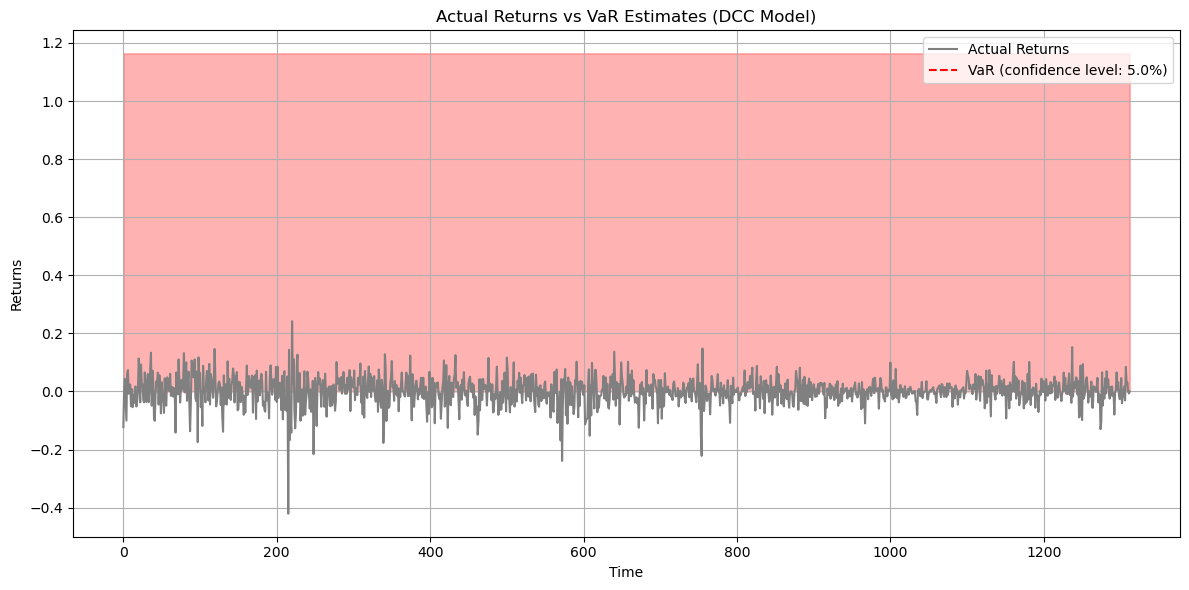

In [58]:
alpha = 0.05
VaR = dcc_model.calculate_var(alpha)

# Backtesting logic
violations = returns_data < VaR
n_obs = len(returns_data)
n_violations = np.sum(violations)
expected_violations = n_obs * alpha

# Calculate p-value using Kupiec's test
p_value = 1 - norm.cdf((n_violations - expected_violations) / np.sqrt(expected_violations * (1 - alpha)))

print(f"Number of violations: {n_violations}")
print(f"Expected violations (at {alpha*100}% confidence level): {expected_violations}")
print(f"P-value (Kupiec's test): {p_value}")

plt.figure(figsize=(12, 6))
plt.plot(returns_data, label='Actual Returns', color='gray')
plt.plot(VaR, label=f'VaR (confidence level: {alpha*100}%)', color='red', linestyle='--')
plt.fill_between(range(len(returns_data)), 0, VaR, where=violations, interpolate=True, color='red', alpha=0.3)
plt.title('Actual Returns vs VaR Estimates (DCC Model)')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

**DCC VaR Backtesting results**

- Number of Violations: There were 1313 violations where actual returns exceeded the VaR estimates, suggesting more frequent and severe losses than expected.

- Expected Violations: The expected number of violations for a correctly specified model would be around 65.65, based on a 5% VaR level and the total number of observations.

- Kupiec's Test P-value: With a p-value of 0.0, the test strongly rejects the hypothesis that the model is correctly capturing the risk, indicating that the VaR model underestimates the risk significantly.

**The DCC model used for estimating VaR does not perform well in accurately capturing the tail risk of the portfolio, as evidenced by the much higher than expected number of violations and the results of Kupiec’s test.**

### ADCC model

In [59]:
adcc_model = ADCC(returns_data)
omega_est, alpha_est, beta_est, gamma_est, neg_log_likelihood = adcc_model.fit()

print("Estimated ADCC Parameters:")
print(f"Omega: {omega_est}")
print(f"Alpha: {alpha_est}")
print(f"Beta: {beta_est}")
print(f"Gamma: {gamma_est}")

Estimated ADCC Parameters:
Omega: 0.09242509584739074
Alpha: 2.3799779377157604
Beta: -0.3351346645199641
Gamma: -1.0374498441244397


**ADCC model results interpretation:**

- Omega (Ω): A value of approximately 0.09 indicates the starting point for the variance calculations, which is relatively low, suggesting moderate initial volatility.

- Alpha (α): The value is unusually high and greater than 1, which is typically not feasible in these models as it would imply an increasing error variance over time, potentially leading to instability in the model. This could be a sign of model mis-specification or estimation errors.

- Beta (β): A negative beta is problematic in variance models as it implies negative contributions to variance calculations, which can lead to non-positive definite covariance matrices. This is typically not acceptable as it contradicts the fundamental properties expected in a variance-covariance matrix.

- Gamma (γ): Like beta, a negative gamma is unusual and may indicate an improper response to market shocks, where negative developments might paradoxically reduce estimated volatilities and correlations.

In [60]:
alpha = 0.05
VaR = adcc_model.calculate_var(alpha)

# Backtesting logic
violations = returns_data < VaR
n_obs = len(returns_data)
n_violations = np.sum(violations)
expected_violations = n_obs * alpha

# Calculate p-value using Kupiec's test
p_value = 1 - norm.cdf((n_violations - expected_violations) / np.sqrt(expected_violations * (1 - alpha)))

print(f"Number of violations: {n_violations}")
print(f"Expected violations (at {alpha*100}% confidence level): {expected_violations}")
print(f"P-value (Kupiec's test): {p_value}")

Number of violations: 1313
Expected violations (at 5.0% confidence level): 65.65
P-value (Kupiec's test): 0.0


**ADCC VaR Backtesting results**

- Number of Violations: There were 1313 violations where actual returns exceeded the VaR estimates, suggesting more frequent and severe losses than expected.

- Expected Violations: The expected number of violations for a correctly specified model would be around 65.65, based on a 5% VaR level and the total number of observations.

- Kupiec's Test P-value: With a p-value of 0.0, the test strongly rejects the hypothesis that the model is correctly capturing the risk, indicating that the VaR model underestimates the risk significantly.

**The ADCC model used for estimating VaR does not perform well in accurately capturing the tail risk of the portfolio, as evidenced by the much higher than expected number of violations and the results of Kupiec’s test.**

### cDCC model

In [62]:
cdcc_model = cDCC(returns_data)

# Fit the model
Omega_est, A_est, B_est, neg_log_likelihood = cdcc_model.fit()

# Print estimated parameters
print("Estimated cDCC Parameters:")
print(f"Omega: {Omega_est}")
print(f"Alpha: {A_est}")
print(f"Beta: {B_est}")

Estimated cDCC Parameters:
Omega: [[0.06]]
Alpha: [[0.44]]
Beta: [[0.28]]


**cDCC model results interpretation:**

- Omega (Ω): A value of 0.06 suggests a relatively modest level of baseline variance. This parameter sets the initial conditions for the dynamic correlation calculations.

- Alpha (α): A positive value for alpha, such as 0.44, suggests that past volatility or squared shocks increase future conditional correlations, which supports typical financial behavior and the positive definiteness required in covariance models.

- Beta (β): A positive value for beta, like 0.28 suggests that past conditional correlations positively impact future correlations, leading to potentially positive definite covariance matrices. This is valid as correlations and volatilities are positive.

In [63]:
alpha = 0.05
VaR = cdcc_model.calculate_var(alpha)

# Backtesting logic
violations = returns_data < VaR
n_obs = len(returns_data)
n_violations = np.sum(violations)
expected_violations = n_obs * alpha

# Calculate p-value using Kupiec's test
p_value = 1 - norm.cdf((n_violations - expected_violations) / np.sqrt(expected_violations * (1 - alpha)))

print(f"Number of violations: {n_violations}")
print(f"Expected violations (at {alpha*100}% confidence level): {expected_violations}")
print(f"P-value (Kupiec's test): {p_value}")

Number of violations: 1313
Expected violations (at 5.0% confidence level): 65.65
P-value (Kupiec's test): 0.0


**cDCC VaR Backtesting results**

- Number of Violations: There were 1313 violations where actual returns exceeded the VaR estimates, suggesting more frequent and severe losses than expected.

- Expected Violations: The expected number of violations for a correctly specified model would be around 65.65, based on a 5% VaR level and the total number of observations.

- Kupiec's Test P-value: With a p-value of 0.0, the test strongly rejects the hypothesis that the model is correctly capturing the risk, indicating that the VaR model underestimates the risk significantly.

**The cDCC model used for estimating VaR does not perform well in accurately capturing the tail risk of the portfolio, as evidenced by the much higher than expected number of violations and the results of Kupiec’s test.**

**Conclusion:**

***While MGARCH models like BEKK, DCC, ADCC, and cDCC are powerful tools for modeling complex dependencies in financial time series, their performance in VaR backtesting can vary. Success depends on careful model specification, robust estimation procedures, and alignment with the specific characteristics and behaviors of the data being analyzed. In some cases, simpler models or alternative approaches might be more suitable for VaR estimation and backtesting, such as GJR-GARCH(1,1,1) model.***